In [1]:
import os
import sys
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import models


In [2]:
dataset_path = "./Test_Images"
batch_size = 16
epochs = 50

In [3]:
train_dir = "./Test_Images/train"
val_dir = "./Test_Images/val"
test_dir = "./Test_Images/test"

# Create directories for training, validation, and test data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get paths to all image files in the dataset
image_paths = []
class_labels = os.listdir(dataset_path)
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, fname) for fname in os.listdir(class_path)])

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42) 
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

def move_images(image_paths, dest_dir):
    """
    Move images to their respective class directories.
    """
    for img_path in image_paths:
        if os.path.isfile(img_path):
            label = img_path.split('/')[-2]
            class_dest_dir = os.path.join(dest_dir, label)
            os.makedirs(class_dest_dir, exist_ok=True)
            shutil.copy(img_path, class_dest_dir)

# Move images to their respective directories
move_images(train_paths, train_dir)
move_images(val_paths, val_dir)
move_images(test_paths, test_dir)


In [4]:
train_dir = "./Test_Images/train"
val_dir = "./Test_Images/val"
test_dir = "./Test_Images/test"

# Create directories for training, validation, and test data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get paths to all image files in the dataset
image_paths = []
class_labels = os.listdir(dataset_path)
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, fname) for fname in os.listdir(class_path)])

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42) 
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

def move_images(image_paths, dest_dir):
    """
    Move images to their respective class directories.
    """
    for img_path in image_paths:
        if os.path.isfile(img_path):
            label = img_path.split('/')[-2]
            class_dest_dir = os.path.join(dest_dir, label)
            os.makedirs(class_dest_dir, exist_ok=True)
            shutil.copy(img_path, class_dest_dir)

# Move images to their respective directories
move_images(train_paths, train_dir)
move_images(val_paths, val_dir)
move_images(test_paths, test_dir)


In [5]:
print(len(train_paths))
print(len(val_paths))
print(len(test_paths))

2477
310
310


In [6]:
class SuppressTensorFlowOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with SuppressTensorFlowOutput():
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )


In [7]:
# Initialize the base model with InceptionV3
base_model = InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 201ms/step - accuracy: 0.9966 - loss: 0.0142 - val_accuracy: 0.7734 - val_loss: 1.9267
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 1.0000 - loss: 0.0384 - val_accuracy: 0.6429 - val_loss: 2.1614
Epoch 3/50


2024-11-13 14:39:47.361238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:39:47.493811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9991 - loss: 0.0069 - val_accuracy: 0.7637 - val_loss: 1.9230
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8571 - val_loss: 2.2427
Epoch 5/50


2024-11-13 14:40:22.017386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:40:22.160112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9995 - loss: 0.0069 - val_accuracy: 0.7617 - val_loss: 2.0772
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.9286 - val_loss: 0.1019
Epoch 7/50


2024-11-13 14:40:56.745301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:40:56.885048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.9990 - loss: 0.0064 - val_accuracy: 0.7520 - val_loss: 2.1263
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.7857 - val_loss: 1.5283
Epoch 9/50


2024-11-13 14:41:37.244503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:41:37.411730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9977 - loss: 0.0105 - val_accuracy: 0.7559 - val_loss: 2.1121
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 11/50


2024-11-13 14:42:12.099927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:42:12.244419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.9987 - loss: 0.0078 - val_accuracy: 0.7578 - val_loss: 2.1480
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8571 - val_loss: 1.1377
Epoch 13/50


2024-11-13 14:42:48.092319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:42:48.253383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.9472 - loss: 0.1735 - val_accuracy: 0.6719 - val_loss: 2.1905
Epoch 14/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.8125 - loss: 0.6241 - val_accuracy: 0.7143 - val_loss: 1.5973
Epoch 15/50


2024-11-13 14:43:23.563989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:43:23.698484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - accuracy: 0.8839 - loss: 0.3339 - val_accuracy: 0.7129 - val_loss: 1.7223
Epoch 16/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9375 - loss: 0.2435 - val_accuracy: 0.7143 - val_loss: 1.1082
Epoch 17/50


2024-11-13 14:44:00.345603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:44:00.490597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.9686 - loss: 0.1090 - val_accuracy: 0.7207 - val_loss: 2.0707
Epoch 18/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8750 - loss: 0.3417 - val_accuracy: 0.7143 - val_loss: 1.5007
Epoch 19/50


2024-11-13 14:44:34.976289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:44:35.102843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.9916 - loss: 0.0312 - val_accuracy: 0.7637 - val_loss: 2.0975
Epoch 20/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 1.0000 - loss: 0.0220 - val_accuracy: 0.8571 - val_loss: 2.4282
Epoch 21/50


2024-11-13 14:45:10.790100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:45:10.936681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9979 - loss: 0.0132 - val_accuracy: 0.7617 - val_loss: 2.0803
Epoch 22/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8571 - val_loss: 2.1068
Epoch 23/50


2024-11-13 14:45:45.575542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:45:45.704854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.9999 - loss: 0.0046 - val_accuracy: 0.7637 - val_loss: 2.0112
Epoch 24/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.7143 - val_loss: 1.8818
Epoch 25/50


2024-11-13 14:46:21.482894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:46:21.649950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.9994 - loss: 0.0061 - val_accuracy: 0.7715 - val_loss: 2.1368
Epoch 26/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.6429 - val_loss: 1.8648
Epoch 27/50


2024-11-13 14:46:56.999746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:46:57.170933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 0.7598 - val_loss: 2.1262
Epoch 28/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7857 - val_loss: 0.8734
Epoch 29/50


2024-11-13 14:47:30.817250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:47:30.996074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 201ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.7715 - val_loss: 2.1532
Epoch 30/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.6429 - val_loss: 2.1053
Epoch 31/50


2024-11-13 14:48:05.954913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:48:06.107128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.7676 - val_loss: 2.2210
Epoch 32/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.7857 - val_loss: 2.6942
Epoch 33/50


2024-11-13 14:48:40.046956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:48:40.190969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.9990 - loss: 0.0065 - val_accuracy: 0.7676 - val_loss: 2.1396
Epoch 34/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7857 - val_loss: 0.5095
Epoch 35/50


2024-11-13 14:49:15.096586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:49:15.250160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.7715 - val_loss: 2.1712
Epoch 36/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 1.0000 - loss: 4.0850e-04 - val_accuracy: 0.5714 - val_loss: 4.6825
Epoch 37/50


2024-11-13 14:49:48.981229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:49:49.111685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.7676 - val_loss: 2.2162
Epoch 38/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 9.3271e-04 - val_accuracy: 0.7143 - val_loss: 2.1735
Epoch 39/50


2024-11-13 14:50:22.825059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:50:22.999637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 0.7695 - val_loss: 2.1505
Epoch 40/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.7143 - val_loss: 2.6392
Epoch 41/50


2024-11-13 14:50:57.592768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:50:57.747409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 201ms/step - accuracy: 0.9980 - loss: 0.0086 - val_accuracy: 0.7754 - val_loss: 2.1653
Epoch 42/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5714 - val_loss: 4.5110
Epoch 43/50


2024-11-13 14:51:32.777142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:51:32.926779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.7715 - val_loss: 2.2299
Epoch 44/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.1219e-04 - val_accuracy: 0.7143 - val_loss: 3.1694
Epoch 45/50


2024-11-13 14:52:11.553917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:52:11.734292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.7637 - val_loss: 2.1950
Epoch 46/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 1.0000 - loss: 4.1126e-04 - val_accuracy: 0.8571 - val_loss: 1.5472
Epoch 47/50


2024-11-13 14:52:46.152816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:52:46.295129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.7656 - val_loss: 2.3113
Epoch 48/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.5144e-04 - val_accuracy: 0.8571 - val_loss: 1.4218
Epoch 49/50


2024-11-13 14:53:19.594270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:53:19.763589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 37s 214ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.7676 - val_loss: 2.3238
Epoch 50/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8571 - val_loss: 1.5339


2024-11-13 14:53:56.912547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:53:57.057803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


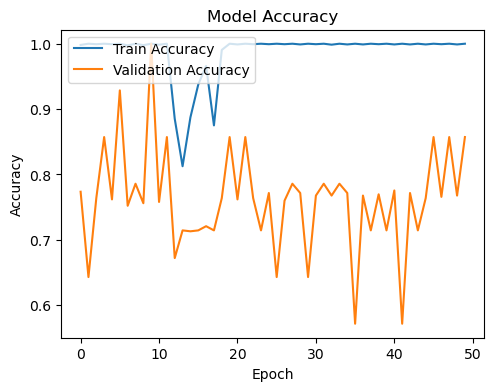

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8168 - loss: 1.9058
